It's important to note that when using PCA, we may not ever know what components are spit out of the algorithm. But the purpose here is to classify, not to necessarily explicitly say what's motivating the classification

In [1]:
import sys
import pickle
sys.path.append("../../courses/machine-learning/ud120-projects/tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import pandas as pd
import pandasql as sql
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Task 1: Select what features you'll use.
`features_list` is a list of strings, each of which is a feature name. The first feature must be "poi".

In [2]:
features_list = ['poi','salary', "total_earned_cash_value", 
                "exercised_stock_options"] # You will need to use more features

In [3]:
# Load dict containing dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
### Two oddities to be dealt with. Robert Belfer's data is incorrectly
### input, as is Sanjay Bhatnagar's.
data_dict["BELFER ROBERT"]["deferred_income"] = -102500
data_dict["BELFER ROBERT"]["deferral_payments"] = 0
data_dict["BELFER ROBERT"]["total_payments"] = 3285
data_dict["BELFER ROBERT"]["exercised_stock_options"] = 0
data_dict["BELFER ROBERT"]["restricted_stock"] = 44093
data_dict["BELFER ROBERT"]["restricted_stock_deferred"] = -44093
data_dict["BELFER ROBERT"]["total_stock_value"] = 0
data_dict["BELFER ROBERT"]["expenses"] = 3285
data_dict["BELFER ROBERT"]["director_fees"] = 102500

data_dict["BHATNAGAR SANJAY"]["expenses"] = 137864
data_dict["BHATNAGAR SANJAY"]["total_payments"] = 137864
data_dict["BHATNAGAR SANJAY"]["total_stock_value"] = 15456290
data_dict["BHATNAGAR SANJAY"]["exercised_stock_options"] = 15456290
data_dict["BHATNAGAR SANJAY"]["restricted_stock"] = 2604490
data_dict["BHATNAGAR SANJAY"]["restricted_stock_deferred"] = -2604490
data_dict["BHATNAGAR SANJAY"]["other"] = 0
data_dict["BHATNAGAR SANJAY"]["director_fees"] = 0

In [5]:
## transform to pandas DF for ease of use
data_df = pd.DataFrame.from_dict(data_dict, orient="index")
data_df.replace("NaN", 0, inplace=True)
data_df.poi = data_df.poi.astype(bool)
data_df.email_address = data_df.email_address.astype("str")
data_df["employee"] = data_df.index

In [6]:
data_df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person,employee
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,2195,152,65,False,0,-3081055,304805,phillip.allen@enron.com,47,ALLEN PHILLIP K
BADUM JAMES P,0,0,178980,182466,257817,0,0,0,0,257817,...,0,0,0,False,0,0,0,0,0,BADUM JAMES P
BANNANTINE JAMES M,477,566,0,916197,4046157,0,1757552,465,-560222,5243487,...,29,864523,0,False,0,-5104,0,james.bannantine@enron.com,39,BANNANTINE JAMES M
BAXTER JOHN C,267102,0,1295738,5634343,6680544,1200000,3942714,0,0,10623258,...,0,2660303,0,False,0,-1386055,1586055,0,0,BAXTER JOHN C
BAY FRANKLIN R,239671,0,260455,827696,0,400000,145796,0,-82782,63014,...,0,69,0,False,0,-201641,0,frank.bay@enron.com,0,BAY FRANKLIN R


Let's just look at everything

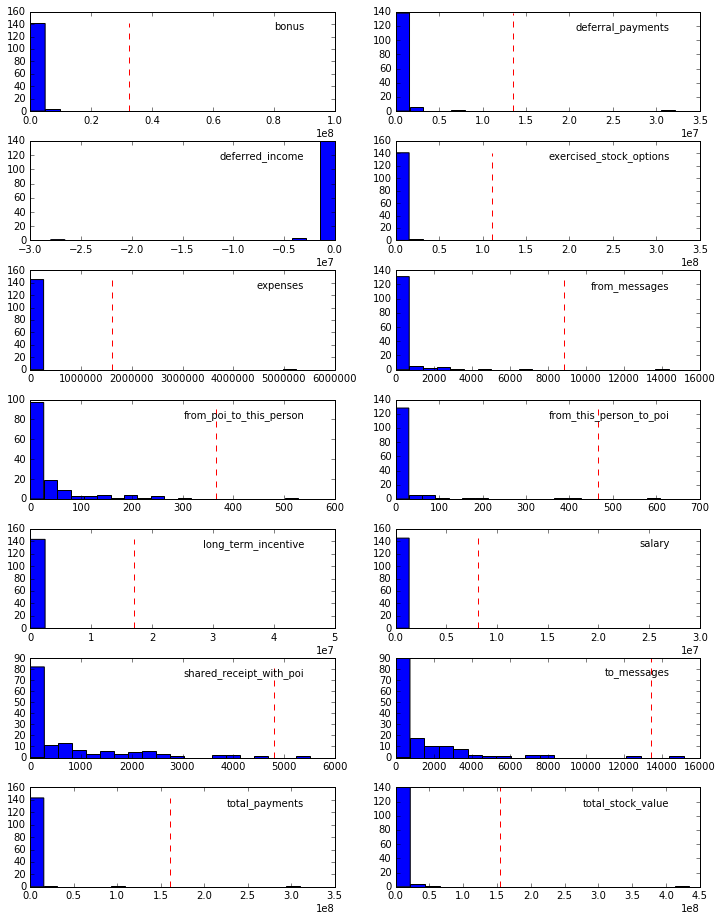

In [17]:
features_list = ["bonus", "deferral_payments", "deferred_income", 
                 "exercised_stock_options", "expenses", "from_messages", 
                 "from_poi_to_this_person", "from_this_person_to_poi", 
                 "long_term_incentive", "salary", "shared_receipt_with_poi",
                 "to_messages", "total_payments", "total_stock_value"]

def many_histograms(the_data, features_list, log=True, pct=0.995):
    fig = plt.figure(figsize=(12,18))
    fig.subplots_adjust(hspace=0.3)
    for ii in range(len(features_list)):
        ax = plt.subplot(len(features_list)/2 + 1, 2, ii+1)
        ax.hist(list(the_data[features_list[ii]]), bins=20)
        H, dum = np.histogram(list(the_data[features_list[ii]]), bins=20)
        ax.plot([the_data[features_list[ii]].quantile(pct), the_data[features_list[ii]].quantile(pct)], 
                [0, max(H)], linestyle="--", color="r")
        ax.text(0.9, 0.9, features_list[ii], transform = ax.transAxes, 
                horizontalalignment="right", verticalalignment="top")

        
    plt.show()
    
many_histograms(data_df, features_list)

**These have outliers that should be removed**
- Total payments
- Total stock value
- Long term incentive
- Salary
- From this person to POI
- From POI to this person
- From messages
- Exercised stock options
- Bonus
- Deferral payments

### Task 2: Remove outliers
The first range of outliers would be employees with no
reported salary, no reported total payments, and no total stock value.
I expect my POI classifier will rely on at least one of these (or one of
the components that will contribute to one of the totals), so if all of
these are null (in this case a zero), then they're just not useful

In [8]:
the_query = "SELECT *"
the_query += " FROM data_df"
the_query += " WHERE total_payments!=0 AND salary!=0 AND total_stock_value!=0"
no_null_df = sql.sqldf(the_query, locals())

Let's take another look at everything, with some pruning done

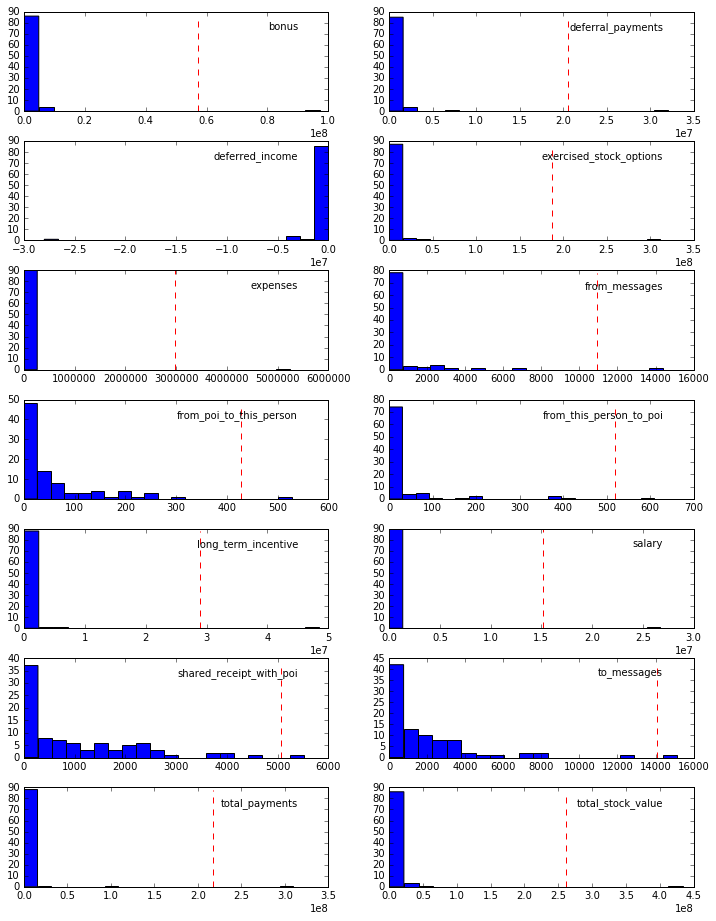

In [9]:
many_histograms(no_null_df, features_list)

### Outlier identification round 2
**These still have high-end outliers to be removed by the 3-$\sigma$ cut**
- Total payments
- Total stock value
- Long term incentive
- Salary
- From this person to POI
- From POI to this person
- From messages
- Exercised stock options
- Bonus
- Deferral payments

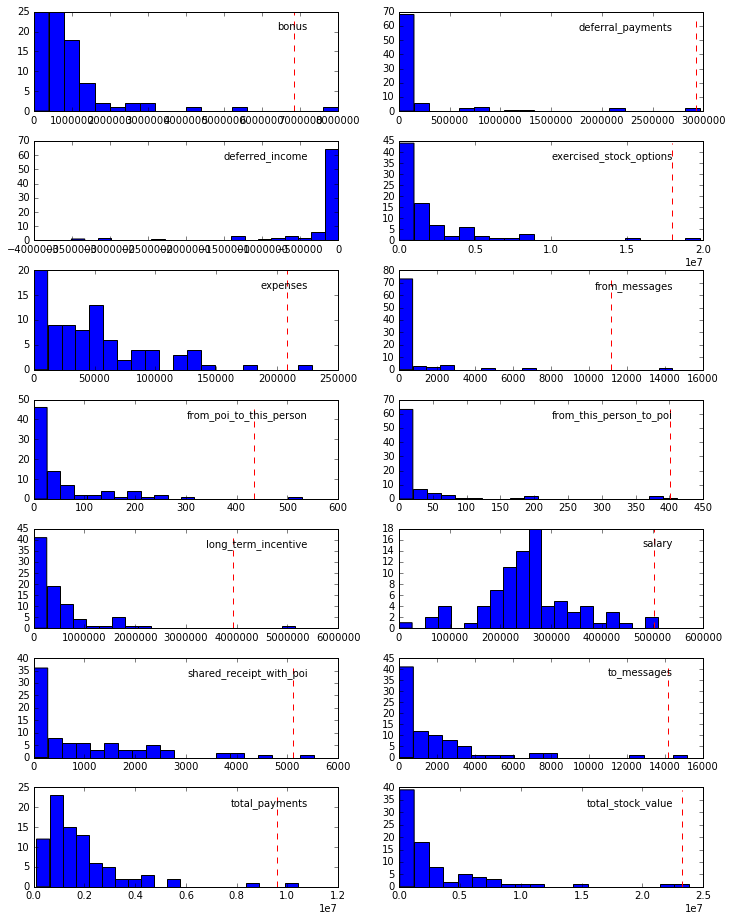

In [19]:
three_sig_cut = (no_null_df.bonus < no_null_df.bonus.quantile(0.995)) & \
    (no_null_df.salary < no_null_df.salary.quantile(0.95)) &\
    (no_null_df.from_this_person_to_poi < no_null_df.from_this_person_to_poi.quantile(0.995)) &\
    (no_null_df.long_term_incentive < no_null_df.long_term_incentive.quantile(0.995)) &\
    (no_null_df.total_stock_value < no_null_df.total_stock_value.quantile(0.995))

no_outliers = no_null_df[three_sig_cut]
many_histograms(no_outliers, features_list)

I think we've done enough pruning. Let's try a logarithmic re-scaling

In [11]:
def single_histo(data, feature):
    fig = plt.figure(figsize=(8, 3))
    ax = plt.subplot(111)
    ax.hist(np.log10(data[feature] + 1), bins=20)
    ax.text(0.95, 0.9, feature, transform=ax.transAxes, horizontalalignment="right")
    plt.show()

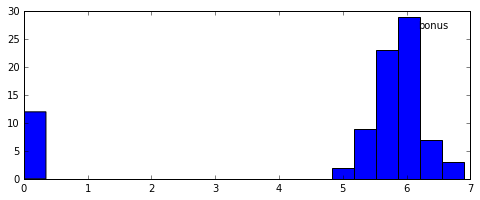

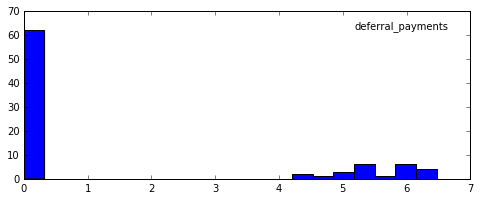

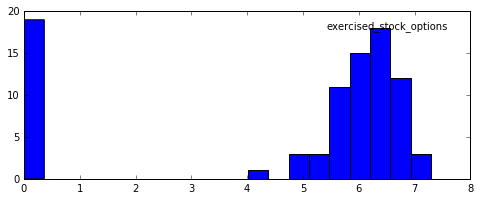

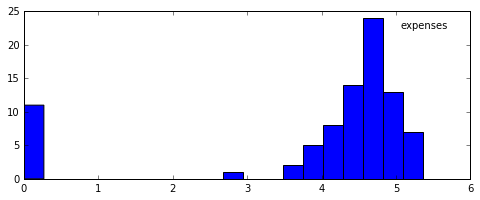

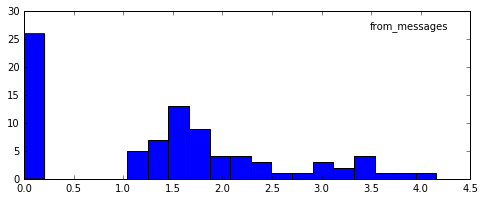

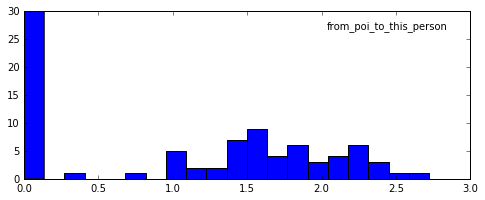

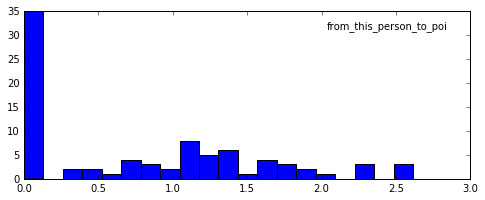

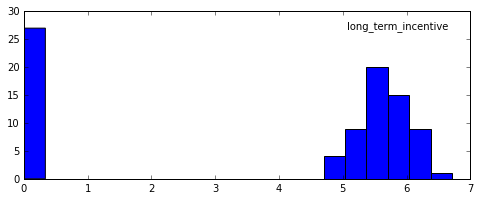

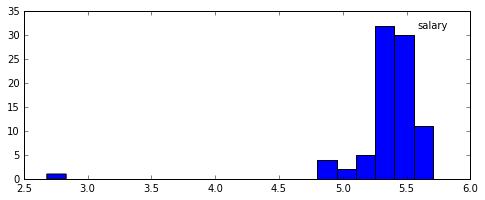

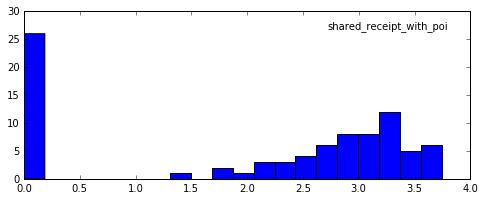

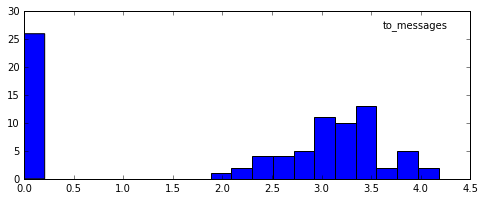

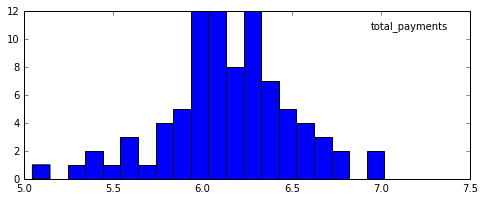

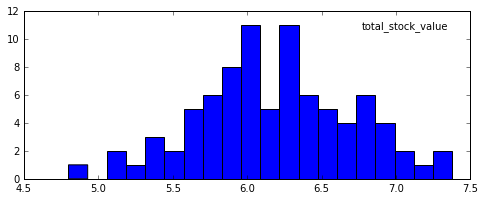

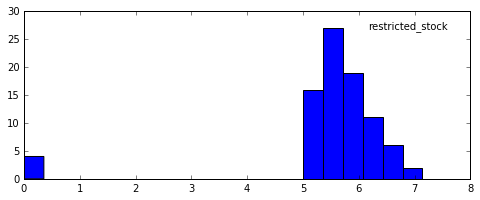

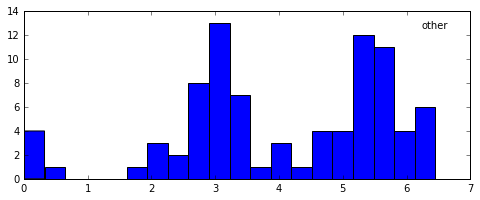

In [20]:
these_feats = ["bonus", "deferral_payments",
                 "exercised_stock_options", "expenses", "from_messages", 
                 "from_poi_to_this_person", "from_this_person_to_poi", 
                 "long_term_incentive", "salary", "shared_receipt_with_poi",
                 "to_messages", "total_payments", "total_stock_value",
              "restricted_stock", "other"]

for feat in these_feats:
    single_histo(no_outliers, feat)

**If used, log-scale these**
- bonus
- exercised_stock_options
- expenses
- long_term_incentive
- salary
- shared_receipt_with_poi (maybe)
- to_messages
- total_payments
- total_stock_value
- restricted_stock
- other

Lastly, check which features are actually used by the persons of interest. No good training a classifier on features that don't describe persons of interest

In [22]:
the_query = "SELECT to_messages, bonus, shared_receipt_with_poi, from_messages,"
the_query += " other, from_this_person_to_poi, from_poi_to_this_person"
the_query += " FROM no_outliers"
the_query += " WHERE poi = 1"
sql.sqldf(the_query, locals())

,to_messages,bonus,shared_receipt_with_poi,from_messages,other,from_this_person_to_poi,from_poi_to_this_person
0,7991,5249999,5521,484,210698,108,228
1,1858,1350000,1593,27,1621,15,140
2,2598,1250000,2188,144,486,25,199
3,1892,1000000,1585,49,307895,12,58
4,1758,1200000,1132,40,101740,11,240
5,0,1300000,0,0,277464,0,0
6,873,600000,874,16,200308,6,52
7,1045,1500000,1035,32,11350,21,32
8,2374,700000,2271,61,150458,15,53
9,0,800000,0,0,907502,0,0


These are the columns where at *most* 3 of remaining POI (18.75%) are missing data,
and thus will be our feature list moving forward:
- salary (log) | 0 missing
- to_messages (log) | 3 missing
- total_payments (log) | 0 missing
- bonus (log) | 1 missing
- restricted_stock (log) | 0 missing
- shared_receipt_with_poi | 3 missing
- total_stock_value (log) | 0 missing
- from_messages | 3 missing
- other (log) | 0 missing
- from_this_person_to_poi | 3 missing
- from_poi_to_this_person | 3 missing
- expenses (log) | 0 missing

Initial pruning done. Let's look at everything vs everything

In [14]:
def megaplot(the_data, features):
    indx = 1
    poi = the_data.poi == True

    fig = plt.figure(figsize=(18,18))

    for ii in range(len(features)):
        for jj in range(len(features)):
            if ii != jj:
                ax = plt.subplot(len(features), len(features) - 1, indx)
                x = the_data[features[jj]]
                y = the_data[features[ii]]
                    
                ax.scatter(list(x[~poi]), 
                           list(y[~poi]), 
                           c="b", s=10, edgecolor="None")
                
                ax.scatter(list(x[poi]), 
                           list(y[poi]), 
                           c="r", s=10, edgecolor="None")
                
                ax.set_xticklabels([])
#                 ax.set_ylim([min(y), max(y)])
#                 ax.set_yticklabels([])
                if (jj == 0) or ((jj == 1) & (ii == 0)):
                    ax.set_ylabel(features[ii])
                    
                indx += 1
    plt.show()

In [23]:
no_outliers["log_salary"] = np.log10(no_outliers.salary + 1)
no_outliers["log_to_messages"] = np.log10(no_outliers.to_messages + 1)
no_outliers["log_total_payments"] = np.log10(no_outliers.total_payments + 1)
no_outliers["log_bonus"] = np.log10(no_outliers.bonus + 1)
no_outliers["log_restricted_stock"] = np.log10(no_outliers.restricted_stock + 1)
no_outliers["log_total_stock_value"] = np.log10(no_outliers.total_stock_value + 1)
no_outliers["log_other"] = np.log10(no_outliers.other + 1)
no_outliers["log_long_term_incentive"] = np.log10(no_outliers.long_term_incentive + 1)
no_outliers["log_expenses"] = np.log10(no_outliers.expenses + 1)

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

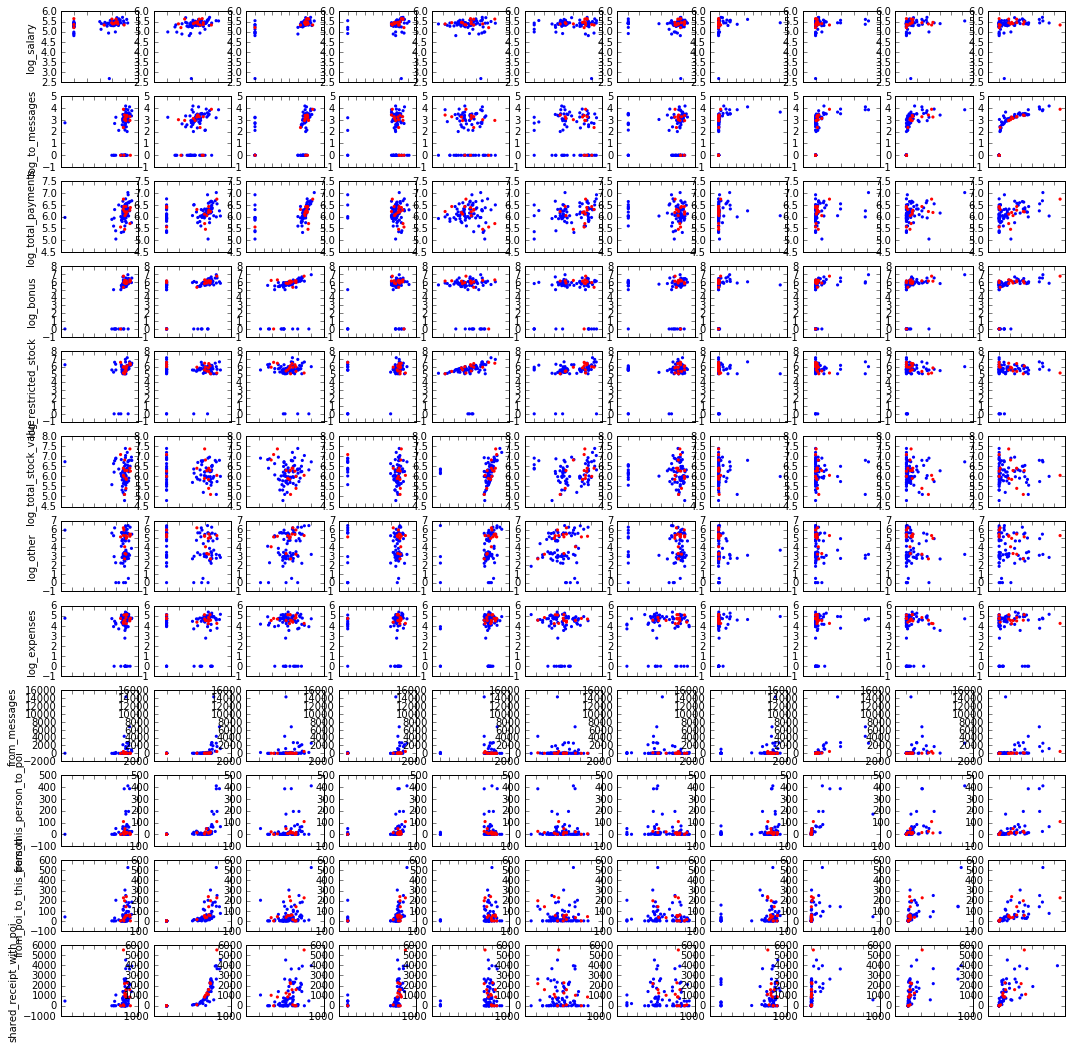

In [26]:
features_list = ["log_salary", "log_to_messages", "log_total_payments", "log_bonus",
                "log_restricted_stock", "log_total_stock_value", "log_other",
                "log_expenses", "from_messages",
                "from_this_person_to_poi", "from_poi_to_this_person", "shared_receipt_with_poi"]
# features_list = ["log_salary", 
#                 "log_restricted_stock", "log_other",
#                 "log_expenses"]

megaplot(no_outliers, features_list)

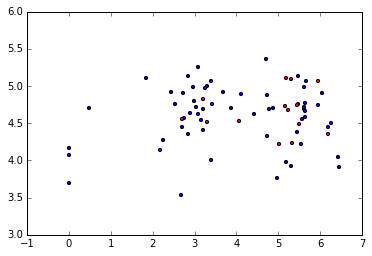

In [45]:
poi = no_outliers.poi == True
plt.scatter(no_outliers[~poi].log_other, no_outliers[~poi].log_expenses, c='b', s=10)
plt.scatter(no_outliers[poi].log_other, no_outliers[poi].log_expenses, c='r', s=10)
# plt.xlim(0,10)
plt.ylim(3, 6.0)
plt.show()

### Task 3: Create new feature(s)
One new feature to create will be `total_earned_cash_value`, combining
`salary, bonus, director_fees, expenses, loan_advances, long_term_incentive, deferral_payments` / 0.9, and -(`deferred_income`)

Another new feature: `stocks_cash_ratio`

In [33]:
new_col = "stocks_cash_ratio"
no_outliers[new_col] = no_outliers.total_stock_value / no_outliers.total_payments

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


New features: `total_emails`, `fractions_sent`, `fractions_received`

In [59]:
no_outliers["total_emails"] = no_outliers[["from_messages", "to_messages"]].sum(axis=1)
no_outliers["fractions_sent"] = no_outliers.from_messages / no_outliers.total_emails.astype(float)
no_outliers["fractions_received"] = no_outliers.to_messages / no_outliers.total_emails.astype(float)

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [61]:
my_data = no_outliers.fillna(0).to_dict(orient="index")

for key in my_data:
    the_name = my_data[key]["employee"]
    my_data[the_name] = my_data.pop(key)

### Extract features and labels from dataset for local testing
Rewriting this so that it works with my dataframe

In [70]:
# features_list = ["poi", "total_payments", "total_stock_value", "fractions_received", 
#                  "fractions_sent", "total_earned_cash_value", "other"]
features_list = ["poi", "log_other", "log_expenses", "total_emails", "fractions_sent"]
data = featureFormat(my_data, features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)

### Task 4: Try a Variety of Classifiers
Please name your classifier clf for easy export below.
Note that if you want to do PCA or other multi-stage operations,
you'll need to use Pipelines. For more info:
http://scikit-learn.org/stable/modules/pipeline.html

Let's start by finding some principal components amongst *all* features

In [82]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cross_validation import train_test_split

In [50]:
def evaluate_classifiers(classifier_dict, features, labels):
    features_train, features_test, labels_train, labels_test = train_test_split(
        features, labels, test_size = 0.5, random_state = 42
    )
    
    for classifier in classifier_dict.keys():
        clf = classifier_dict[classifier]
        clf.fit(features_train, labels_train)
        pred = clf.predict(features_test)
        print "%s: \n\tAccuracy - %.6f \n\tPrecision - %.6f \n\tRecall - %.6f\n" % (classifier, 
                                                                                    accuracy_score(labels_test, pred), 
                                                                                    precision_score(labels_test, pred), 
                                                                                    recall_score(labels_test, pred))

In [84]:
classifiers = {"GaussianNB" : GaussianNB(), 
               "Decision Tree" : DecisionTreeClassifier(random_state=5),
              "KNearest" : KNeighborsClassifier(),
              "SVC" : SVC(C = 0.1),
               "LinearSVC" : LinearSVC(),
              "KMeans" : KMeans(random_state=5),
              "RandomForestClassifier" : RandomForestClassifier(),
              "AdaBoostClassifier" : AdaBoostClassifier(),
              "BaggingClassifier" : BaggingClassifier(),
              "ExtraTreesClassifier" : ExtraTreesClassifier(),
              "GradientBoostingClassifier" : GradientBoostingClassifier(),
              "RidgeClassifier" : RidgeClassifier()}

evaluate_classifiers(classifiers, features, labels)

KMeans: 
	Accuracy - 0.116279 
	Precision - 0.598007 
	Recall - 0.116279

ExtraTreesClassifier: 
	Accuracy - 0.813953 
	Precision - 0.000000 
	Recall - 0.000000

Decision Tree: 
	Accuracy - 0.697674 
	Precision - 0.125000 
	Recall - 0.142857

AdaBoostClassifier: 
	Accuracy - 0.744186 
	Precision - 0.300000 
	Recall - 0.428571

BaggingClassifier: 
	Accuracy - 0.837209 
	Precision - 0.500000 
	Recall - 0.142857

SVC: 
	Accuracy - 0.837209 
	Precision - 0.000000 
	Recall - 0.000000

LinearSVC: 
	Accuracy - 0.837209 
	Precision - 0.000000 
	Recall - 0.000000

RandomForestClassifier: 
	Accuracy - 0.813953 
	Precision - 0.400000 
	Recall - 0.285714

GaussianNB: 
	Accuracy - 0.767442 
	Precision - 0.384615 
	Recall - 0.714286

RidgeClassifier: 
	Accuracy - 0.837209 
	Precision - 0.000000 
	Recall - 0.000000

KNearest: 
	Accuracy - 0.837209 
	Precision - 0.000000 
	Recall - 0.000000

GradientBoostingClassifier: 
	Accuracy - 0.744186 
	Precision - 0.166667 
	Recall - 0.142857



/Users/Nick/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/Nick/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
 

`GaussianNB` appears to be the ticket. It doesn't, however, appear to be tuneable

In [72]:
? GaussianNB()